## Import

In [3]:
pip install geopandas shapely

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import zipfile
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV

In [5]:
df_train = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/train.zip', compression='zip')
df_test = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/test.zip', compression='zip')

df_train.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory - - before sending to the vendor because the vehicle did not have a connection to the server - - - - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds

# Struttura di base del progetto:
Dopo aver caricato i dati in un DataFrame Pandas, i passi sono:

1. Esplorazione preliminare (EDA – Exploratory Data Analysis)

Verifica lo schema delle colonne (df_train.info()) e fai alcune statistiche descrittive (df_train.describe()).
Osserva eventuali valori mancanti o outlier.
Analizza la distribuzione della variabile target, in questo caso “trip_duration”.

2. Feature Engineering

Puoi creare variabili aggiuntive a partire da quelle fornite (ad esempio, estrarre l’ora del giorno dalla data di pickup, calcolare la distanza tra latitudine e longitudine se non è già presente, distinguere i giorni feriali dai festivi, ecc.).
Verifica se la “distanza euclidea” o la “distanza calcolata con l’Haversine” tra i punti di pickup e dropoff migliora la predizione della durata.

3. Preparazione del dataset

Dividi il dataset in training e validation (oppure usa tecniche di cross-validation).
Assicurati di codificare correttamente le variabili categoriche (se presenti).

4. Scelta e addestramento di un modello

Inizia con modelli semplici (Linear Regression o Regressori lineari) per avere un benchmark iniziale.
Prova algoritmi più potenti, come Random Forest, Gradient Boosting (ad es. XGBoost, LightGBM, CatBoost), e confronta le prestazioni.
Tieni traccia della metrica richiesta dalla competizione: in questo caso, spesso si usa Root Mean Squared Logarithmic Error (RMSLE) o RMSE sulla variabile “trip_duration”.

5. Valutazione e tuning

Fai hyperparameter tuning sui modelli utilizzando tecniche come Grid Search o Random Search (oppure ottimizzazione bayesiana) per migliorare le prestazioni.
Valuta con set di validazione e, quando sei soddisfatto, genera la submission.

6. Creazione della Submission

Prepara le predizioni sulla base del test set (il file test.csv) e confrontale col sample_submission.csv per garantire il formato corretto.
Salva un file CSV (ad esempio submission.csv) con l’ID del viaggio e la colonna con la durata prevista.

7. Consigli generali
Versioning: salva diverse versioni del Notebook, in modo da poter sempre tornare a un checkpoint precedente.
Documentazione: aggiungi commenti e Markdown con spiegazioni, soprattutto se presenti i risultati ad altre persone (o a te stesso in futuro).
Pulizia dei dati: presta attenzione ai valori anomali (ad esempio, viaggi con durata “0” o distanze improbabili). Talvolta conviene filtrarli o trattarli come eccezioni.


## Data exploration

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [7]:
df_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


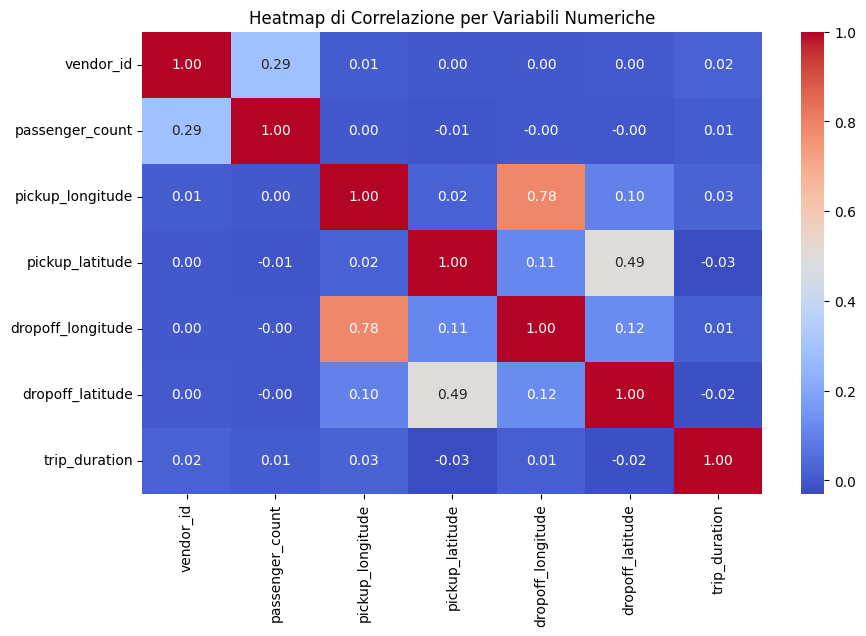

In [8]:
# Esempio: selezioniamo le colonne numeriche
numeric_cols = df_train.select_dtypes(include=[np.number]).columns

# Calcolo della matrice di correlazione
corr_matrix = df_train[numeric_cols].corr()

# Visualizzazione della heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap di Correlazione per Variabili Numeriche')
plt.show()

Do chi-squared test

In [9]:
# Questo codice non va perhè la tabella di contingenza che viene generata è troppo grande.
# Quindi conviene che prima si faccia un po' di features engine sulle varaibili con le date.

'''# Lista delle variabili categoriche da analizzare
lista_variabili1 = ['pickup_datetime', 'dropoff_datetime','store_and_fwd_flag']

# Ciclo per calcolare il test del Chi-quadrato per ogni variabile
print('--------------------------------')
for var1 in lista_variabili1:
    for var2 in lista_variabili1:
        if var1!= var2:
            print("Varaibile: ",var1,' con: ',var2)
    # Calcolo della tabella di contingenza
            contingenza = pd.crosstab(df_train[var1], df_train[var2])
    # Esecuzione del test del Chi-quadrato
            chi2, p_value, dof, expected = stats.chi2_contingency(contingenza)
        
        # Stampa dei risultati
            print(f"  Chi-quadrato: {chi2:.3f}")
            print(f"  p-value: {p_value:.3f}")
            print('--------------------------------')'''

'# Lista delle variabili categoriche da analizzare\nlista_variabili1 = [\'pickup_datetime\', \'dropoff_datetime\',\'store_and_fwd_flag\']\n\n# Ciclo per calcolare il test del Chi-quadrato per ogni variabile\nprint(\'--------------------------------\')\nfor var1 in lista_variabili1:\n    for var2 in lista_variabili1:\n        if var1!= var2:\n            print("Varaibile: ",var1,\' con: \',var2)\n    # Calcolo della tabella di contingenza\n            contingenza = pd.crosstab(df_train[var1], df_train[var2])\n    # Esecuzione del test del Chi-quadrato\n            chi2, p_value, dof, expected = stats.chi2_contingency(contingenza)\n        \n        # Stampa dei risultati\n            print(f"  Chi-quadrato: {chi2:.3f}")\n            print(f"  p-value: {p_value:.3f}")\n            print(\'--------------------------------\')'

Esempi di possibili outlier
1. Trip duration = 0 o prossimi a zero secondi/minuti.
2. Trip duration estremamente lunghi (ad esempio, giorni interi).
3. Coordinate lontanissime da NYC o inconsistenze (pickup e drop-off identici ma con enorme durata).
4. Numero passeggeri eccessivo o nullo (ad es. 0 o > 6/7, che non rientra nella normalità).

In [10]:
df_train['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

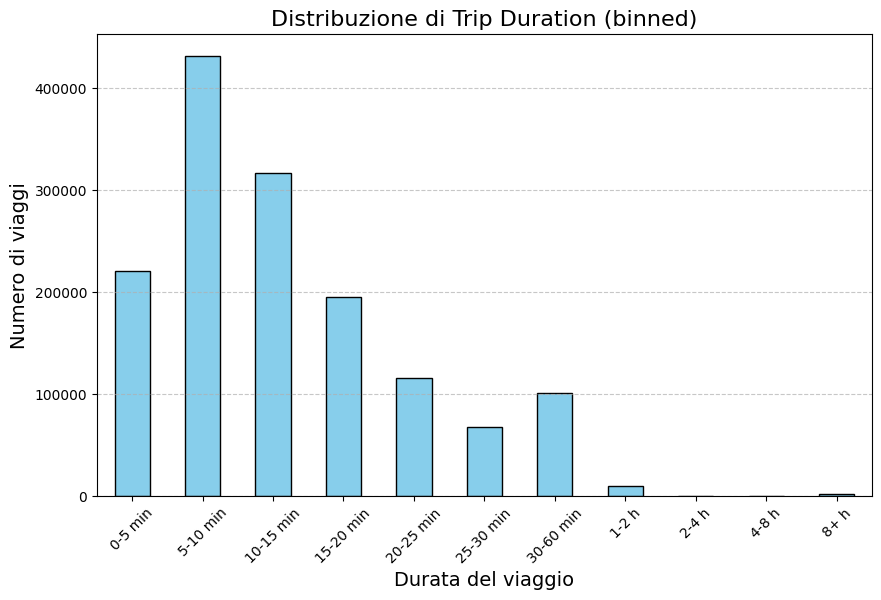

In [11]:
# Creare i bin per il trip_duration (in secondi)
bins = [0, 300, 600, 900, 1200, 1500, 1800, 3600, 7200, 14400, 28800, np.inf]  # Durata in secondi
labels = [
    "0-5 min", "5-10 min", "10-15 min","15-20 min", "20-25 min", "25-30 min", "30-60 min",
    "1-2 h", "2-4 h", "4-8 h", "8+ h"
]

# Creare una colonna con le categorie binned
df_train['trip_duration_binned'] = pd.cut(df_train['trip_duration'], bins=bins, labels=labels, right=False)

# Contare il numero di osservazioni per ciascun bin
bin_counts = df_train['trip_duration_binned'].value_counts(sort=False)

# Ordinare in base ai bin
bin_counts = bin_counts.sort_index()

# Visualizzare l'istogramma
plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Aggiungere titolo e etichette
plt.title('Distribuzione di Trip Duration (binned)', fontsize=16)
plt.xlabel('Durata del viaggio', fontsize=14)
plt.ylabel('Numero di viaggi', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


IQR (Interquartile Range):
Si calcola l’IQR = Q3 − Q1, dove Q1 e Q3 sono rispettivamente il 25° e 75° percentile.
Si definisce come outlier un valore che è al di sotto di Q1 − 1.5*IQR o al di sopra di Q3 + 1.5*IQR.
Per la variabile trip_duration, puoi filtrare quei viaggi che superano il limite superiore (o inferiore) stabilito.

In [12]:
# Calcolo dei quartili per la variabile trip_duration
Q1 = df_train['trip_duration'].quantile(0.25)  # 25° percentile
Q3 = df_train['trip_duration'].quantile(0.75)  # 75° percentile
IQR = Q3 - Q1  # Interquartile Range

# Limiti per identificare gli outlier
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR

# Filtraggio dei dati per rimuovere gli outlier
df = df_train[(df_train['trip_duration'] >= lower_bound) & (df_train['trip_duration'] <= upper_bound)]

# Stampa dei limiti e del numero di righe dopo il filtraggio
print(f"Limite inferiore: {lower_bound}")
print(f"Limite superiore: {upper_bound}")
print(f"Numero di righe dopo il filtraggio: {len(df)}")

Limite inferiore: -959.0
Limite superiore: 2431.0
Numero di righe dopo il filtraggio: 1411096


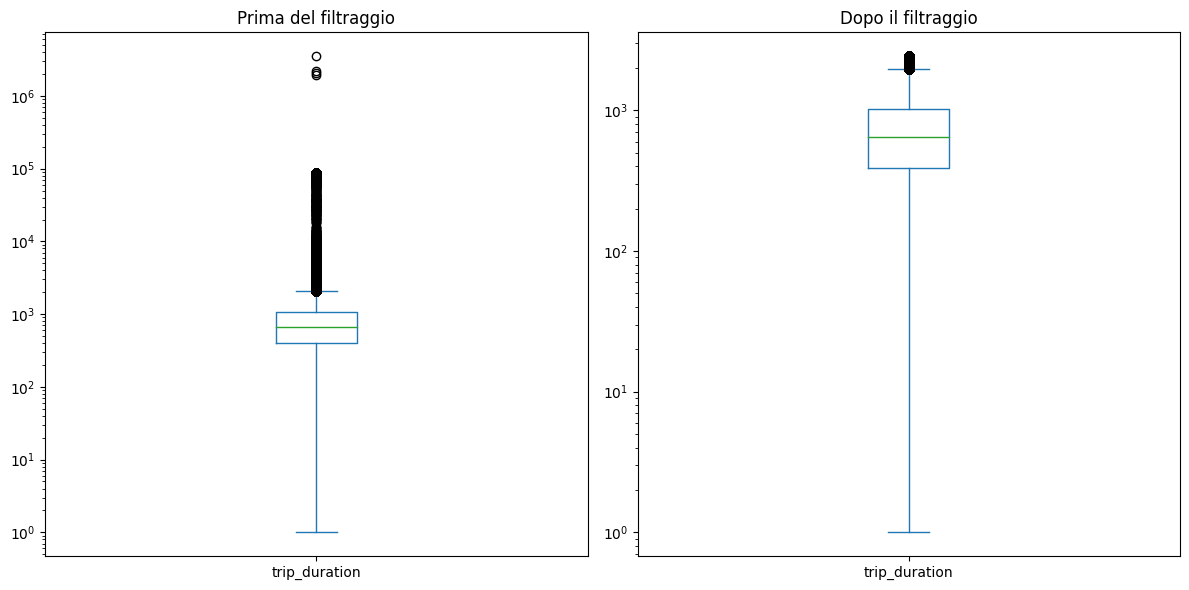

In [13]:
plt.figure(figsize=(12, 6))

# Prima del filtraggio
plt.subplot(1, 2, 1)
df_train['trip_duration'].plot(kind='box', title='Prima del filtraggio')
plt.yscale('log')  # Scala logaritmica se i valori variano molto

# Dopo il filtraggio
plt.subplot(1, 2, 2)
df['trip_duration'].plot(kind='box', title='Dopo il filtraggio')
plt.yscale('log')

plt.tight_layout()
plt.show()


<ipython-input-14-03ba2832976a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trip_duration_binned'] = pd.cut(df['trip_duration'], bins=bins, labels=labels, right=False)


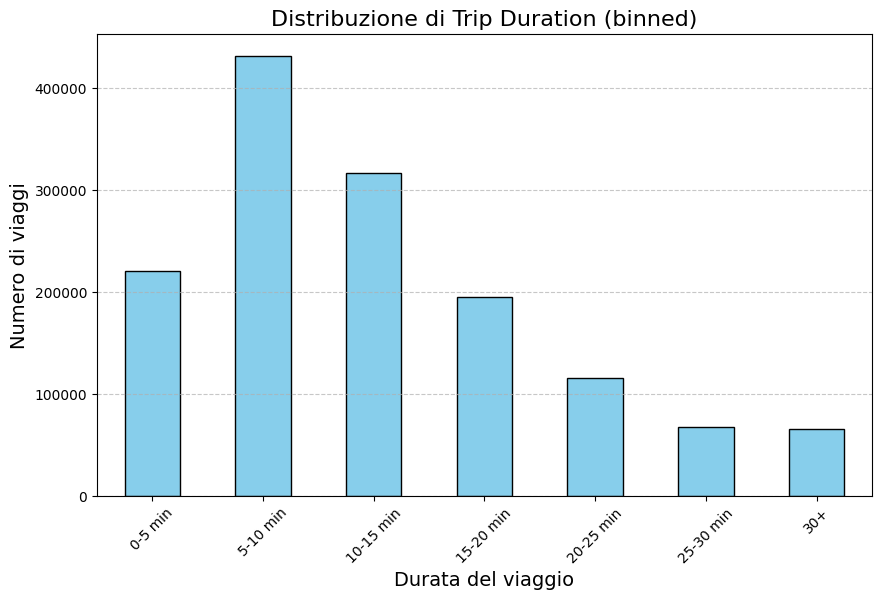

In [14]:
# Creare i bin per il trip_duration (in secondi)
bins = [0, 300, 600, 900, 1200, 1500, 1800, np.inf]  # Durata in secondi
labels = [
    "0-5 min", "5-10 min", "10-15 min","15-20 min", "20-25 min", "25-30 min", "30+"]
    

# Creare una colonna con le categorie binned
df['trip_duration_binned'] = pd.cut(df['trip_duration'], bins=bins, labels=labels, right=False)

# Contare il numero di osservazioni per ciascun bin
bin_counts = df['trip_duration_binned'].value_counts(sort=False)

# Ordinare in base ai bin
bin_counts = bin_counts.sort_index()

# Visualizzare l'istogramma
plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Aggiungere titolo e etichette
plt.title('Distribuzione di Trip Duration (binned)', fontsize=16)
plt.xlabel('Durata del viaggio', fontsize=14)
plt.ylabel('Numero di viaggi', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [15]:
print('-------------------------------------')
print(df_train['trip_duration'].describe())
print('-------------------------------------')
print(df['trip_duration'].describe())
print('-------------------------------------')

-------------------------------------
count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64
-------------------------------------
count    1.411096e+06
mean     7.603384e+02
std      4.896415e+02
min      1.000000e+00
25%      3.890000e+02
50%      6.430000e+02
75%      1.020000e+03
max      2.431000e+03
Name: trip_duration, dtype: float64
-------------------------------------


<ipython-input-16-401c1735df04>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trip_duration_binned'] = pd.cut(df['trip_duration'], bins=bins, labels=labels, right=False)


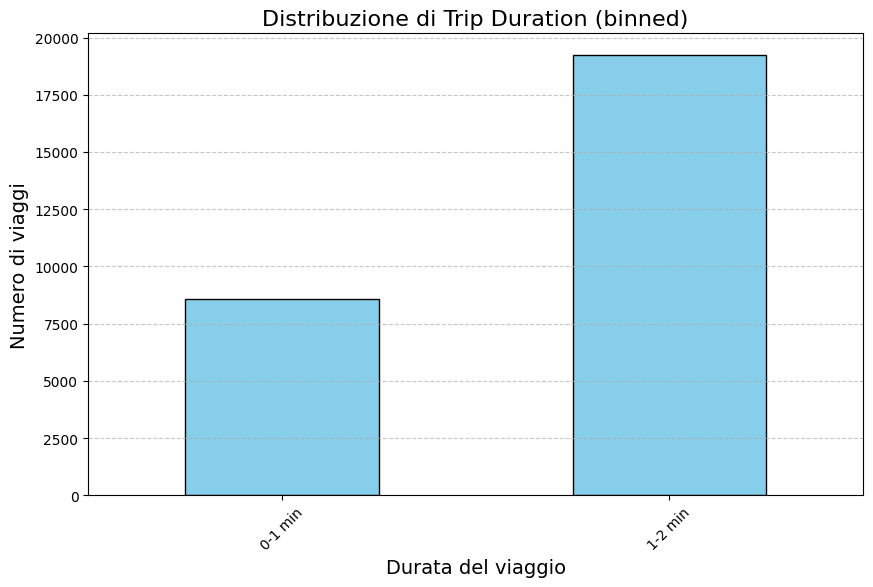

In [16]:
# Creare i bin per il trip_duration (in secondi)
bins = [0, 60, 120]  # Durata in secondi
labels = [
    "0-1 min", "1-2 min"]
    

# Creare una colonna con le categorie binned
df['trip_duration_binned'] = pd.cut(df['trip_duration'], bins=bins, labels=labels, right=False)

# Contare il numero di osservazioni per ciascun bin
bin_counts = df['trip_duration_binned'].value_counts(sort=False)

# Ordinare in base ai bin
bin_counts = bin_counts.sort_index()

# Visualizzare l'istogramma
plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Aggiungere titolo e etichette
plt.title('Distribuzione di Trip Duration (binned)', fontsize=16)
plt.xlabel('Durata del viaggio', fontsize=14)
plt.ylabel('Numero di viaggi', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Now we remove the istances that are classificated like "outliers".
NB: For lower_bound we choise like treshold 2 minute (120 seconds).

In [17]:
df = df_train[(df_train['trip_duration'] <= upper_bound) & (df_train['trip_duration'] >= 120)]
len(df)                          # Questo è il valore trovato prima con la differenza tra terzo e primo quartile

1383279

<ipython-input-18-03ba2832976a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trip_duration_binned'] = pd.cut(df['trip_duration'], bins=bins, labels=labels, right=False)


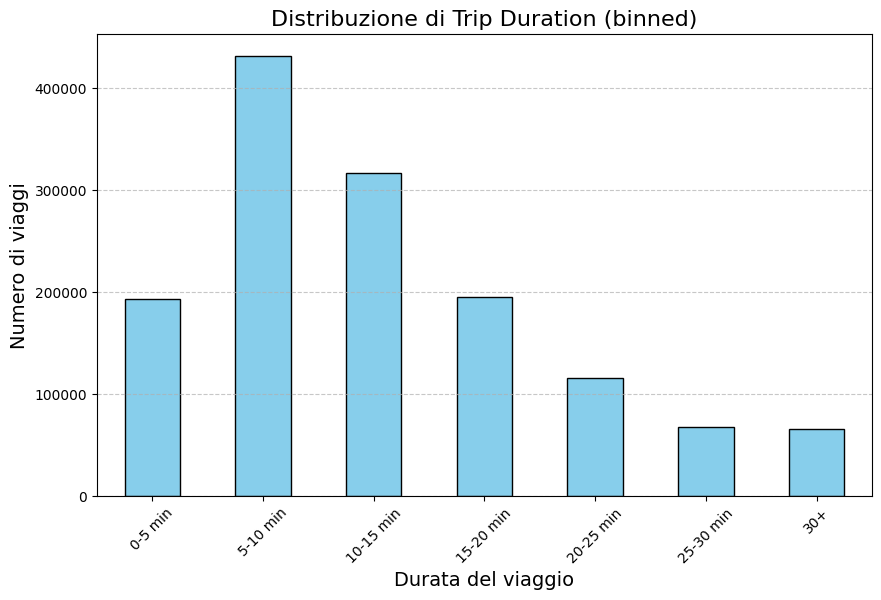

In [18]:
# Creare i bin per il trip_duration (in secondi)
bins = [0, 300, 600, 900, 1200, 1500, 1800, np.inf]  # Durata in secondi
labels = [
    "0-5 min", "5-10 min", "10-15 min","15-20 min", "20-25 min", "25-30 min", "30+"]
    

# Creare una colonna con le categorie binned
df['trip_duration_binned'] = pd.cut(df['trip_duration'], bins=bins, labels=labels, right=False)

# Contare il numero di osservazioni per ciascun bin
bin_counts = df['trip_duration_binned'].value_counts(sort=False)

# Ordinare in base ai bin
bin_counts = bin_counts.sort_index()

# Visualizzare l'istogramma
plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Aggiungere titolo e etichette
plt.title('Distribuzione di Trip Duration (binned)', fontsize=16)
plt.xlabel('Durata del viaggio', fontsize=14)
plt.ylabel('Numero di viaggi', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [19]:
df.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_binned
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,5-10 min
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,10-15 min
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,30+


## Feature Engineering

Remove the id-variable and "dropoff_date_time" for training set (couse we don't have the feature in test set)

In [20]:
df = df[['vendor_id','pickup_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration']]

df_test = df_test[['vendor_id','pickup_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag']]

Now we want to see if we can do something about the "saptial" variables:

['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude']

In [21]:
# Real geographic distance (with haversine formula)
R = 6371  # Raggio medio della Terra in km
def haversine(lat1, lon1, lat2, lon2):
    # Convertire le coordinate da gradi a radianti
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Formula dell'haversine
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Displacement angle (Bearing)
def calculate_bearing(lat1, lon1, lat2, lon2):
    # Convertire le coordinate da gradi a radianti
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Calcolo del bearing
    dlon = lon2 - lon1
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    initial_bearing = np.arctan2(x, y)
    # Convertire il bearing da radianti a gradi
    initial_bearing = np.degrees(initial_bearing)
    # Portare l'angolo nel range [0, 360)
    bearing = (initial_bearing + 360) % 360
    return bearing

**Displacement angle** tells us if the trip is oriented **north**(near 0°), **east*(90°), **south**(180°) or **west**(270°).


In [22]:
df['distance_km'] = df.apply(
    lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'],
                          row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
df['bearing'] = df.apply(
    lambda row: calculate_bearing(row['pickup_latitude'], row['pickup_longitude'],
                                  row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
df.head(3)

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance_km,bearing
0,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498521,99.970196
1,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805507,242.846232
2,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385098,200.319835


In [23]:
# Do same for test_set:
df_test['distance_km'] = df_test.apply(
    lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'],
                          row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

df_test['bearing'] = df_test.apply(
    lambda row: calculate_bearing(row['pickup_latitude'], row['pickup_longitude'],
                                  row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
df_test.head(3)

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,distance_km,bearing
0,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,2.746426,356.404776
1,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,2.759239,172.278835
2,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,1.306155,133.326248


In [24]:
# Carica i confini dei borough (GeoJSON o Shapefile)
boroughs = gpd.read_file("/kaggle/input/borough-boundaries-geojson/Borough Boundaries.geojson")  # Sostituisci con il file corretto
boroughs = boroughs[['boro_name', 'geometry']]  # Tieni solo il nome del distretto e i poligoni

# Crea punti geografici per pickup e dropoff nel training set
df['pickup_point'] = df.apply(lambda row: Point(row['pickup_longitude'], row['pickup_latitude']), axis=1)
df['dropoff_point'] = df.apply(lambda row: Point(row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

# Crea punti geografici per pickup e dropoff nel test set
df_test['pickup_point'] = df_test.apply(lambda row: Point(row['pickup_longitude'], row['pickup_latitude']), axis=1)
df_test['dropoff_point'] = df_test.apply(lambda row: Point(row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

# Converti i DataFrame in GeoDataFrame
gdf_pickup = gpd.GeoDataFrame(df, geometry='pickup_point', crs=boroughs.crs)
gdf_dropoff = gpd.GeoDataFrame(df, geometry='dropoff_point', crs=boroughs.crs)

gdf_pickup_test = gpd.GeoDataFrame(df_test, geometry='pickup_point', crs=boroughs.crs)
gdf_dropoff_test = gpd.GeoDataFrame(df_test, geometry='dropoff_point', crs=boroughs.crs)

# Funzione per assegnare il borough o "not_known"
def assign_borough(point, boroughs):
    for _, row in boroughs.iterrows():
        if point.within(row['geometry']):
            return row['boro_name']
    return 'not_known'

# Assegna il distretto per pickup e dropoff nel training set
df['pickup_borough'] = gdf_pickup['pickup_point'].apply(lambda x: assign_borough(x, boroughs))
df['dropoff_borough'] = gdf_dropoff['dropoff_point'].apply(lambda x: assign_borough(x, boroughs))

# Assegna il distretto per pickup e dropoff nel test set
df_test['pickup_borough'] = gdf_pickup_test['pickup_point'].apply(lambda x: assign_borough(x, boroughs))
df_test['dropoff_borough'] = gdf_dropoff_test['dropoff_point'].apply(lambda x: assign_borough(x, boroughs))

# Rimuovi le colonne temporanee nel training e test set
df = df.drop(columns=['pickup_point', 'dropoff_point'])
df_test = df_test.drop(columns=['pickup_point', 'dropoff_point'])

KeyboardInterrupt: 

Now work on the time features (like data "pickup_datetime")

We want obtain a different features for explain year, month, day, hour and minute (the variable "minutes" maybe can adds an further information i.e. at past hour there were a recurrent event like trains arrivals or other) 

Ecco una valutazione delle variabili che hai creato:

- Minuti (minute):

Ragionamento:
La variabile "minuti" rappresenta i minuti esatti all'interno dell'ora (ad esempio, 17:24 → 24 minuti).
Tuttavia, è improbabile che il minuto esatto influenzi significativamente la durata di un viaggio, dato che non c'è una relazione logica evidente tra i minuti e la durata.
Cosa fare:
Puoi rimuovere la variabile minute o provare a sostituirla con una variabile che rappresenti fasce orarie più ampie (ad esempio, quarti d'ora: 0-15, 15-30, ecc.).

- Ora del giorno (hour):

Ragionamento:
L'ora del giorno potrebbe influenzare il traffico e quindi la durata del viaggio. Ad esempio, ore di punta (8-10 o 17-19) potrebbero avere viaggi più lunghi rispetto a orari notturni.
Cosa fare:
Mantieni la variabile hour o trasformala in categorie che rappresentano fasce orarie (esempio: "notte", "mattina", "pomeriggio", "sera").

- Giorno (day):

Ragionamento:
Il giorno potrebbe influenzare la durata del viaggio se i dati coprono un lungo periodo e ci sono pattern specifici (ad esempio, fine settimana più traffico). Se invece tutti i dati sono di un singolo mese, day potrebbe non essere molto informativo.
Cosa fare:
Mantieni questa variabile solo se ci sono variazioni significative legate al giorno.

- Mese (month):

Ragionamento:
Il mese è utile solo se ci sono variazioni stagionali significative (ad esempio, meno traffico in estate). Tuttavia, se i dati coprono un solo anno e il target è locale, potrebbe non aggiungere valore.
Cosa fare:
Mantienila solo se i dati coprono più mesi.

In [ ]:
# Per il training set
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['hour'] = df['pickup_datetime'].dt.hour      # Ore del giorno
df['day'] = df['pickup_datetime'].dt.day        # Giorno
df['month'] = df['pickup_datetime'].dt.month    # Mese
df['year'] = df['pickup_datetime'].dt.year      # Anno

# Aggiungi giorno della settimana (weekday)
df['weekday'] = df['pickup_datetime'].dt.weekday

# Aggiungi combinazione mese/giorno
df['month_day'] = df['month'].astype(str) + '/' + df['day'].astype(str)

# Per il test set
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])
df_test['hour'] = df_test['pickup_datetime'].dt.hour      # Ore del giorno
df_test['day'] = df_test['pickup_datetime'].dt.day        # Giorno
df_test['month'] = df_test['pickup_datetime'].dt.month    # Mese
df_test['year'] = df_test['pickup_datetime'].dt.year      # Anno

# Aggiungi giorno della settimana (weekday)
df_test['weekday'] = df_test['pickup_datetime'].dt.weekday

# Aggiungi combinazione mese/giorno
df_test['month_day'] = df_test['month'].astype(str) + '/' + df_test['day'].astype(str)

# Rimuovi l'anno (non utile perché è costante)
df = df.drop(columns=['year'])
df_test = df_test.drop(columns=['year'])
df = df.drop(columns=['pickup_datetime'], errors='ignore')
df_test = df_test.drop(columns=['pickup_datetime'], errors='ignore')

In [ ]:
print(df.shape)
print(df_test.shape)
print(df.columns)
print(df_test.columns)
df.head(3)

## Data Preparation

In [23]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['month_day'] = le.fit_transform(df['month_day'])
df_test['month_day'] = le.transform(df_test['month_day'])

In [24]:
df['passenger_count'] = df['passenger_count'].astype('int8')
df['hour'] = df['hour'].astype('int8')
df['day'] = df['day'].astype('int8')
df['month'] = df['month'].astype('int8')
df['vendor_id'] = df['vendor_id'].astype('int8')
df['weekday'] = df['weekday'].astype('int8')
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N': 0, 'Y': 1}).astype(int)

df_test['passenger_count'] = df_test['passenger_count'].astype('int8')
df_test['hour'] = df_test['hour'].astype('int8')
df_test['day'] = df_test['day'].astype('int8')
df_test['month'] = df_test['month'].astype('int8')
df_test['vendor_id'] = df_test['vendor_id'].astype('int8')
df_test['weekday'] = df_test['weekday'].astype('int8')
df_test['store_and_fwd_flag'] = df_test['store_and_fwd_flag'].map({'N': 0, 'Y': 1}).astype(int)

Split in train and validation. Preparing data for training deep NN.

In [25]:
X = df.drop(columns=['trip_duration'])
y = df['trip_duration']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
print(X_train.dtypes)

vendor_id                int8
passenger_count          int8
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag      int64
distance_km           float64
bearing               float64
hour                     int8
day                      int8
month                    int8
weekday                  int8
month_day               int64
dtype: object


In [27]:
X_train

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,distance_km,bearing,hour,day,month,weekday,month_day
1276903,1,1,-73.964943,40.755619,-73.968437,40.764809,0,1.063375,343.934061,8,19,1,1,10
986346,2,1,-73.975594,40.681622,-73.967422,40.711349,0,3.376610,11.768921,9,27,6,0,171
133005,2,2,-73.991158,40.750610,-73.979118,40.678501,0,8.082128,172.783708,0,19,4,1,101
1046760,2,4,-73.993233,40.729431,-73.914352,40.763542,0,7.651337,60.256575,0,19,6,6,162
1109594,2,1,-74.008179,40.717979,-73.961472,40.756699,0,5.832868,42.412970,21,6,4,2,117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116251,2,1,-73.999130,40.744530,-73.961113,40.766930,0,4.056839,52.110871,22,8,4,4,119
273286,1,1,-73.951813,40.781578,-73.938835,40.792507,0,1.634201,41.953126,19,13,2,5,35
139116,2,2,-73.981903,40.768585,-73.917595,40.758331,0,5.534769,101.867259,0,10,5,1,122
707544,2,1,-73.987984,40.756851,-74.002655,40.755997,0,1.239402,265.608059,14,17,4,6,99


normalizziamo i dati

In [28]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## Train the model

## First Model

In [37]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Output per la regressione
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitora la perdita sul validation set
    factor=0.5,          # Riduce il learning rate del 50%
    patience=3,          # Numero di epoche senza miglioramenti significativi
    min_delta=1e-4,      # Miglioramento minimo richiesto (ad esempio 1e-4  ->  0.0001)
    min_lr=1e-6,         # Limite minimo per il learning rate
    verbose=1            # Mostra messaggi quando il learning rate viene ridotto
)
early_stopping= EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 256)                 │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,105 (184.00 KB)

 Trainable params: 47,105 (184.00 KB)

 Non-trainable params: 0 (0.00 B)

#### Formula for MAE

The formula to calculate the MAE is as follows:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

Where:
- $n$ is the total number of observations.
- $y_i$ is the actual target value for observation \(i\).
- $\hat{y}_i$ is the predicted value by the model for observation \(i\).
- $|y_i - \hat{y}_i|$ is the absolute error for observation \(i\).

In [38]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[reduce_lr, early_stopping],  # callback
    verbose=1
)

Epoch 1/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 171673.2188 - mae: 310.2812 - val_loss: 83290.9844 - val_mae: 212.7956 - learning_rate: 0.0010
Epoch 2/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 85559.0625 - mae: 216.7747 - val_loss: 79617.6875 - val_mae: 204.7533 - learning_rate: 0.0010
Epoch 3/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 80520.4922 - mae: 208.8421 - val_loss: 76503.3359 - val_mae: 209.4030 - learning_rate: 0.0010
Epoch 4/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 77901.7109 - mae: 204.5035 - val_loss: 87616.7422 - val_mae: 235.5762 - learning_rate: 0.0010
Epoch 5/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 75387.8047 - mae: 200.6857 - val_loss: 71359.3125 - val_mae: 198.9590 - learning_rate: 0.0010
Epoch 6/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 73493.0938 - mae: 197.3496 - val_loss: 70501.9609 - val_mae: 188.8158 - learning_rate: 0.0010
Epoch 7/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 2

In [39]:
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

Validation Loss: 65368.9062, Validation MAE: 182.9228


Per capire se i valori di Validation MAE sono accettabili, devi confrontarli con il range dei valori effettivi del target:

Validation MAE: È il Mean Absolute Error, quindi indica che il modello ha, in media, un errore di 184.47 secondi (circa 3 minuti) per ogni predizione.
Se il target (trip_duration) ha valori tipicamente nell'ordine di pochi minuti (ad esempio, tra 2 e 15 minuti), allora un errore di 3 minuti potrebbe essere elevato.
Se invece i viaggi durano molto più a lungo (es. 30-60 minuti), allora un errore di 3 minuti potrebbe essere accettabile.

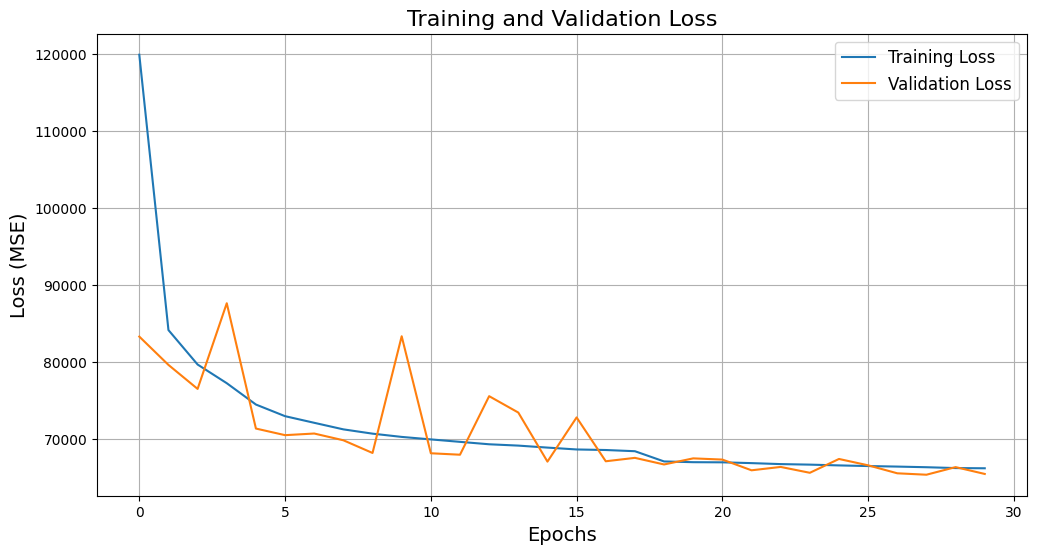

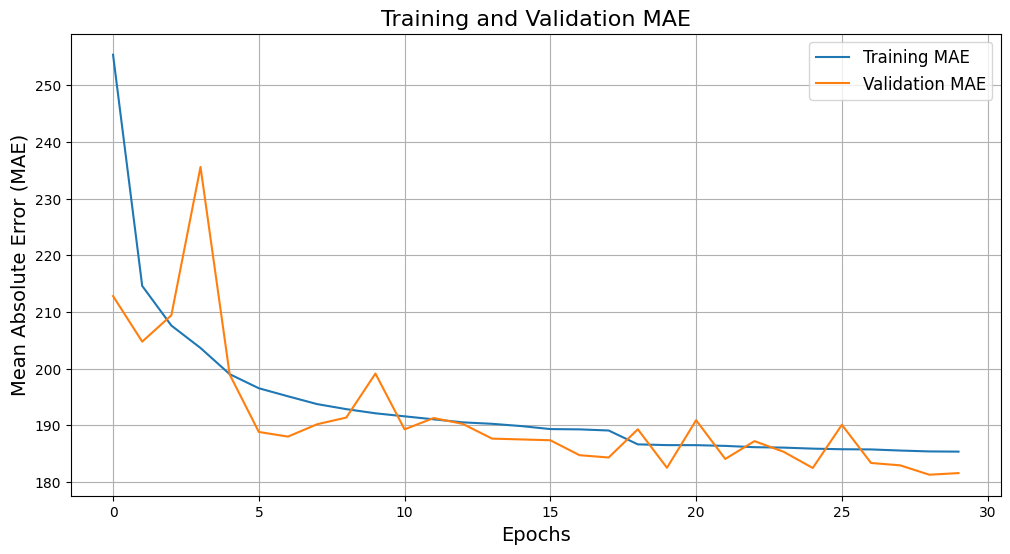

In [40]:
# Recupera i dati dal training
history_dict = history.history

# Loss
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# MAE
train_mae = history_dict['mae']
val_mae = history_dict['val_mae']

# Crea il grafico della loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Crea il grafico del MAE
plt.figure(figsize=(12, 6))
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Training and Validation MAE', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## Second Model

In the first model we created a draft NN. Now let's try to change the input function (because we know that ReLu is not a good choice as an input function).

In [33]:
model2 = Sequential([
    Dense(256, activation='tanh', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Output per la regressione
])
model2.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model2.summary()

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitora la perdita sul validation set
    factor=0.5,          # Riduce il learning rate del 50%
    patience=3,          # Numero di epoche senza miglioramenti significativi
    min_delta=1e-4,      # Miglioramento minimo richiesto (ad esempio 1e-4  ->  0.0001)
    min_lr=1e-6,         # Limite minimo per il learning rate
    verbose=1            # Mostra messaggi quando il learning rate viene ridotto
)
early_stopping= EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,105 (184.00 KB)

 Trainable params: 47,105 (184.00 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[reduce_lr, early_stopping],  # callback
    verbose=1
)

Epoch 1/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 173230.5469 - mae: 311.3700 - val_loss: 84875.6406 - val_mae: 223.5212 - learning_rate: 0.0010
Epoch 2/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 85816.9062 - mae: 217.1670 - val_loss: 81501.7500 - val_mae: 217.6165 - learning_rate: 0.0010
Epoch 3/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 82667.8672 - mae: 211.7770 - val_loss: 79217.1250 - val_mae: 211.7729 - learning_rate: 0.0010
Epoch 4/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 80650.3828 - mae: 208.6765 - val_loss: 80289.7891 - val_mae: 217.7731 - learning_rate: 0.0010
Epoch 5/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 78407.8438 - mae: 205.2515 - val_loss: 75260.2578 - val_mae: 198.0347 - learning_rate: 0.0010
Epoch 6/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 75733.0469 - mae: 200.9938 - val_loss: 75958.0859 - val_mae: 210.6377 - learning_rate: 0.0010
Epoch 7/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 2

In [35]:
val_loss, val_mae = model2.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

Validation Loss: 65243.6094, Validation MAE: 182.0420


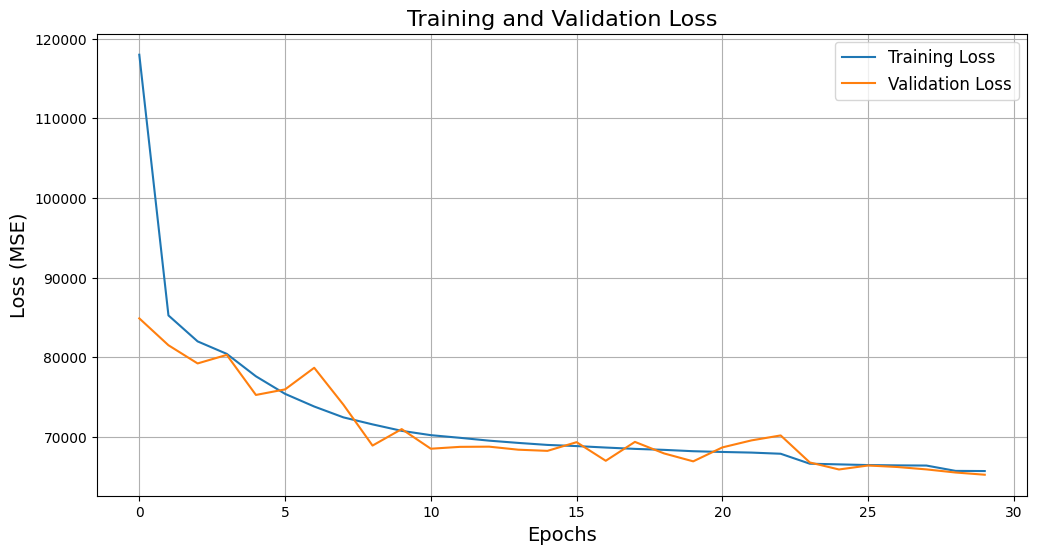

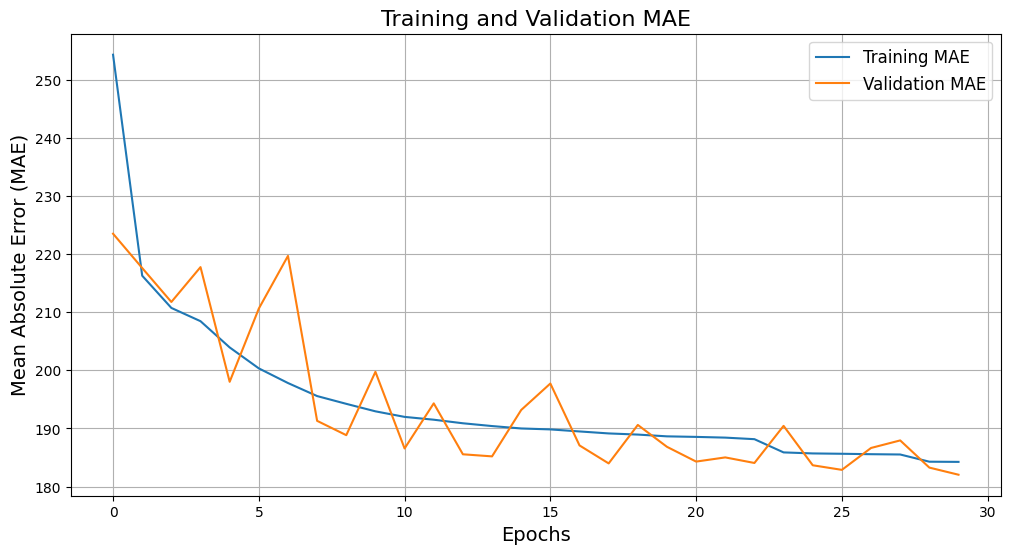

In [36]:
# Recupera i dati dal training
history_dict = history2.history

# Loss
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# MAE
train_mae = history_dict['mae']
val_mae = history_dict['val_mae']

# Crea il grafico della loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Crea il grafico del MAE
plt.figure(figsize=(12, 6))
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Training and Validation MAE', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## Third Model

- add two hidden layers

In [29]:
model3 = Sequential([
    Dense(1024, activation='tanh', input_shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')  # Output per la regressione
])
model3.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model3.summary()

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitora la perdita sul validation set
    factor=0.5,          # Riduce il learning rate del 50%
    patience=3,          # Numero di epoche senza miglioramenti significativi
    min_delta=1e-4,      # Miglioramento minimo richiesto (ad esempio 1e-4  ->  0.0001)
    min_lr=1e-6,         # Limite minimo per il learning rate
    verbose=1            # Mostra messaggi quando il learning rate viene ridotto
)
early_stopping= EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1024)                │          15,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 778,497 (2.97 MB)

 Trainable params: 778,497 (2.97 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history3 = model3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[reduce_lr, early_stopping],  # callback
    verbose=1
)

Epoch 1/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - loss: 144006.0156 - mae: 280.0151 - val_loss: 74586.4062 - val_mae: 197.4739 - learning_rate: 0.0010
Epoch 2/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 79619.0156 - mae: 207.8036 - val_loss: 75040.3203 - val_mae: 191.9455 - learning_rate: 0.0010
Epoch 3/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 75466.9609 - mae: 201.1071 - val_loss: 70736.8047 - val_mae: 194.4192 - learning_rate: 0.0010
Epoch 4/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 73523.8516 - mae: 197.7923 - val_loss: 69294.9375 - val_mae: 192.2142 - learning_rate: 0.0010
Epoch 5/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 71892.0781 - mae: 195.4208 - val_loss: 72392.7266 - val_mae: 202.5868 - learning_rate: 0.0010
Epoch 6/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 71459.7500 - mae: 194.5170 - val_loss: 69292.7969 - val_mae: 196.1489 - learning_rate: 0.0010
Epoch 7/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 4

In [31]:
val_loss, val_mae = model3.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

Validation Loss: 64240.1367, Validation MAE: 181.6832


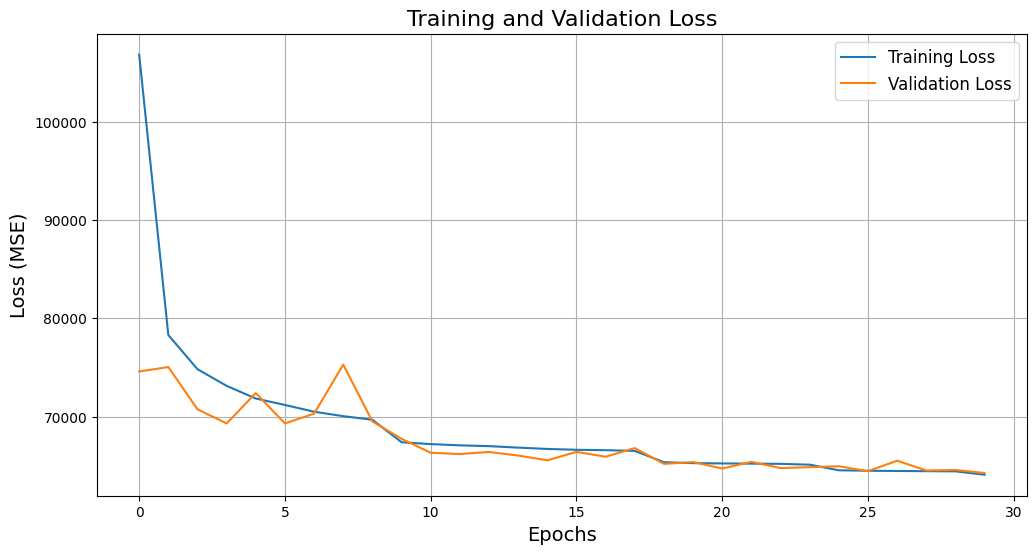

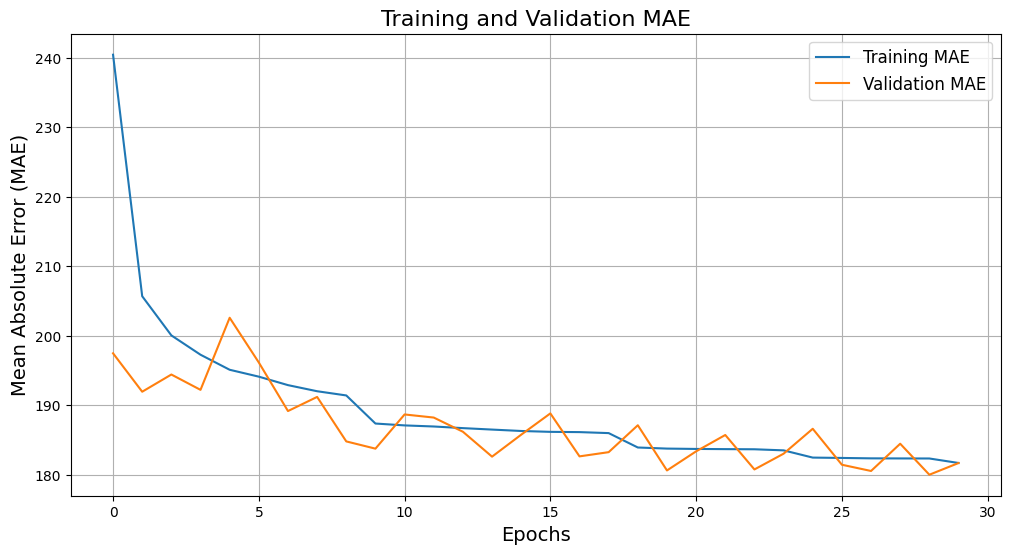

In [32]:
# Recupera i dati dal training
history_dict = history3.history

# Loss
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# MAE
train_mae = history_dict['mae']
val_mae = history_dict['val_mae']

# Crea il grafico della loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Crea il grafico del MAE
plt.figure(figsize=(12, 6))
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Training and Validation MAE', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## Fourth Model

reduced the lr
added parameters and 3 layers

In [65]:
model4 = Sequential([
    Dense(2048, activation='tanh', input_shape=(X_train.shape[1],)),
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')  # Output per la regressione
])
model4.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])
model4.summary()

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitora la perdita sul validation set
    factor=0.5,          # Riduce il learning rate del 50%
    patience=3,          # Numero di epoche senza miglioramenti significativi
    min_delta=1e-4,      # Miglioramento minimo richiesto (ad esempio 1e-4  ->  0.0001)
    min_lr=1e-6,         # Limite minimo per il learning rate
    verbose=1            # Mostra messaggi quando il learning rate viene ridotto
)
early_stopping= EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                     │ (None, 2048)                │          30,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,204,289 (16.04 MB)

 Trainable params: 4,204,289 (16.04 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
history4 = model4.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[reduce_lr, early_stopping],  # callback
    verbose=1
)

Epoch 1/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - loss: 177941.6250 - mae: 313.1370 - val_loss: 80437.1484 - val_mae: 216.8654 - learning_rate: 1.0000e-04
Epoch 2/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - loss: 81265.1797 - mae: 210.7966 - val_loss: 78237.4219 - val_mae: 215.3084 - learning_rate: 1.0000e-04
Epoch 3/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - loss: 74517.4609 - mae: 199.6956 - val_loss: 75137.3438 - val_mae: 192.8323 - learning_rate: 1.0000e-04
Epoch 4/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - loss: 72406.6250 - mae: 196.1420 - val_loss: 68209.0859 - val_mae: 192.2617 - learning_rate: 1.0000e-04
Epoch 5/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - loss: 70777.0547 - mae: 193.5261 - val_loss: 69693.4844 - val_mae: 187.0414 - learning_rate: 1.0000e-04
Epoch 6/30
17291/17291 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - loss: 69850.1484 - mae: 192.0199 - val_loss: 68920.0781 - val_mae: 183.2391 - learning_rate: 1.0000e-04
Epoch 7/30
17291/1729

In [ ]:
val_loss, val_mae = model4.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

Validation Loss: 63347.4375, Validation MAE: 180.9601


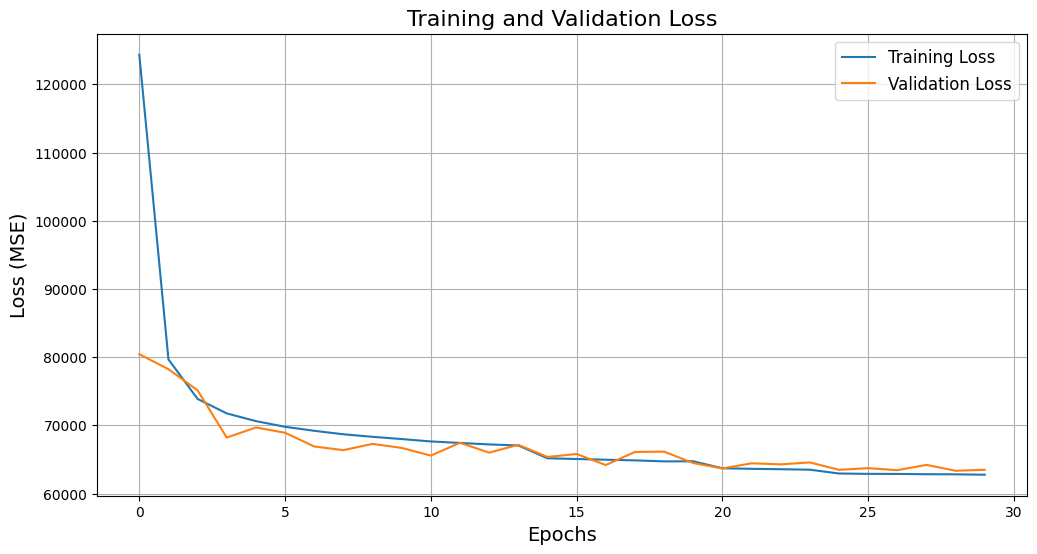

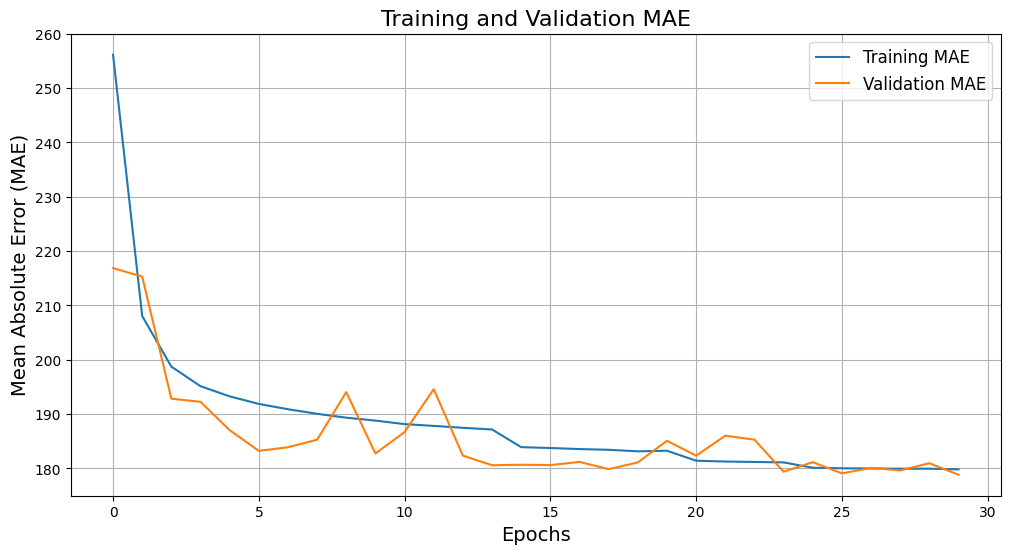

In [ ]:
# Recupera i dati dal training
history_dict = history4.history

# Loss
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# MAE
train_mae = history_dict['mae']
val_mae = history_dict['val_mae']

# Crea il grafico della loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Crea il grafico del MAE
plt.figure(figsize=(12, 6))
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Training and Validation MAE', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## XGboost

- n_estimators: Numero di alberi nella foresta. Un valore più alto può migliorare la performance, ma aumenta il tempo di allenamento.

- max_depth: Controlla la profondità degli alberi. Valori più alti catturano relazioni più complesse, ma rischiano di overfittare.

- learning_rate: Quanto velocemente il modello aggiorna i pesi durante l'allenamento. Valori bassi richiedono più alberi (n_estimators più alto).

- subsample: Percentuale di campioni usati per costruire ogni albero. Aiuta a prevenire l'overfitting.

- colsample_bytree: Percentuale di feature usate per costruire ogni albero. Ridurre il valore può migliorare la generalizzazione.

In [66]:
model = XGBRegressor(
    n_estimators=500,       # Numero di alberi più alto
    max_depth=6,            # Profondità massima (ottimizzata)
    learning_rate=0.05,     # Tasso di apprendimento ridotto
    subsample=0.8,          # Percentuale di campioni
    colsample_bytree=0.8,   # Percentuale di feature
    min_child_weight=5,     # Aumenta il valore per regolarizzazione
    gamma=0.1,              # Regolarizzazione per split
    random_state=42
)

In [67]:
# Allena il modello
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_val, y_val)],  # Valida su validation set
          eval_metric="mae",         # Metriche per il validation set
          early_stopping_rounds=50,  # Interrompi se non migliora per 10 round
          verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [68]:
# Predici sul validation set
y_pred = model.predict(X_val)

# Calcola metriche di valutazione
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)

print(f"Validation MAE: {mae:.4f}")
print(f"Validation MSE: {mse:.4f}")

Validation MAE: 158.8292
Validation MSE: 50151.4089


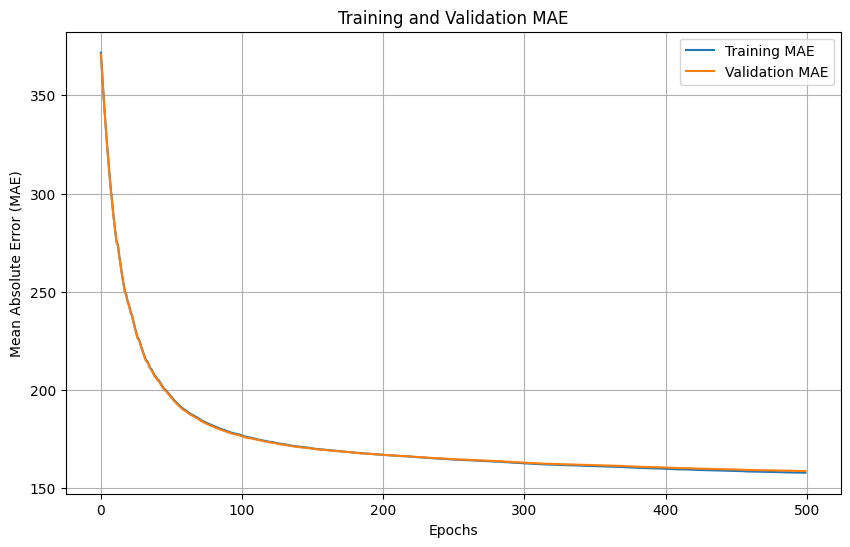

In [69]:
# Ottieni le metriche dal modello
results = model.evals_result()

# Plotta le loss
plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['mae'], label='Training MAE')
plt.plot(results['validation_1']['mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1000x800 with 0 Axes>

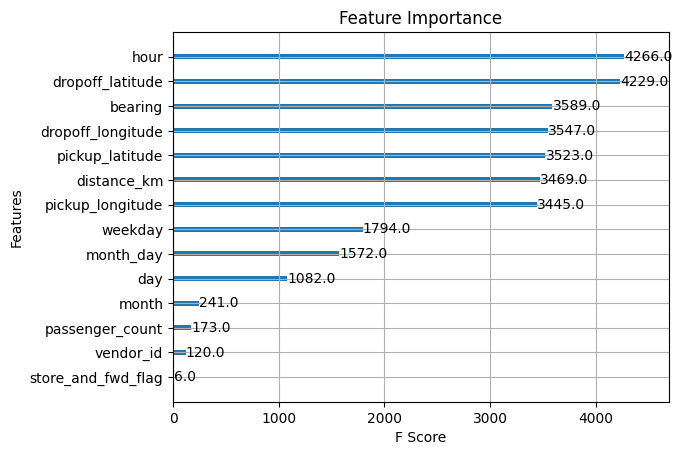

In [70]:
model.get_booster().feature_names = list(X.columns)

plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=20, importance_type="weight", xlabel="F Score")
plt.title("Feature Importance")
plt.show()

## grid search

In [29]:
# Definisci il modello
model = XGBRegressor(random_state=42)

# Definisci il grid dei parametri da testare
param_grid = {
    'n_estimators': [100, 300, 500, 1000],          # Numero di alberi
    'max_depth': [2, 4, 6, 8, 10],                  # Profondità massima
    'learning_rate': [0.001, 0.01, 0.1],      # Tasso di apprendimento
}

# Configura la Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',       # Metrica per la valutazione (usa MAE negativo)
    cv=3,                                   # Numero di fold per la cross-validation
    verbose=2,                              # Livello di verbosità
    n_jobs=-1                               # Usa tutti i core disponibili
)

In [30]:
# Esegui la Grid Search
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [100, 300, 500, 1000]},
             scoring='neg_mean_absolute_error', verbose=2)

In [31]:
# Mostra i migliori parametri e il punteggio
print("Best parameters:", grid_search.best_params_)
print("Best MAE:", -grid_search.best_score_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}
Best MAE: 145.79213429818424


## Final model

In [43]:
model = XGBRegressor(
    n_estimators=2000,       # Più alberi con learning rate più basso
    max_depth=8,             # Alberi meno profondi
    learning_rate=0.01,      # Tasso di apprendimento ridotto
    subsample=0.7,           # Usa solo il 70% dei campioni
    colsample_bytree=0.7,    # Usa solo il 70% delle feature
    min_child_weight=10,     # Peso minimo dei figli aumentato
    gamma=0.2,               # Penalizzazione per split
    reg_alpha=0.1,           # Regolarizzazione L1
    reg_lambda=1.0,          # Regolarizzazione L2
    random_state=42
)

In [44]:
# Allena il modello
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_val, y_val)],  # Valida su validation set
          eval_metric="mae",         # Metriche per il validation set
          early_stopping_rounds=30,  # Interrompi se non migliora per 30 round
          verbose=True)

[0]	validation_0-mae:381.85622	validation_1-mae:380.95815
[1]	validation_0-mae:379.34416	validation_1-mae:378.45467
[2]	validation_0-mae:376.69695	validation_1-mae:375.81484
[3]	validation_0-mae:374.14280	validation_1-mae:373.26664
[4]	validation_0-mae:373.00100	validation_1-mae:372.12664
[5]	validation_0-mae:370.58939	validation_1-mae:369.72202
[6]	validation_0-mae:368.03774	validation_1-mae:367.17936
[7]	validation_0-mae:365.53086	validation_1-mae:364.68114
[8]	validation_0-mae:364.24642	validation_1-mae:363.40317
[9]	validation_0-mae:361.82833	validation_1-mae:360.98999
[10]	validation_0-mae:360.89127	validation_1-mae:360.06051
[11]	validation_0-mae:359.86379	validation_1-mae:359.03730
[12]	validation_0-mae:358.83636	validation_1-mae:358.01325
[13]	validation_0-mae:356.49298	validation_1-mae:355.67700
[14]	validation_0-mae:355.46109	validation_1-mae:354.65348
[15]	validation_0-mae:353.16550	validation_1-mae:352.36412
[16]	validation_0-mae:351.00117	validation_1-mae:350.20705
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [45]:
# Predici sul validation set
y_pred = model.predict(X_val)

# Calcola metriche di valutazione
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)

print(f"Validation MAE: {mae:.4f}")
print(f"Validation MSE: {mse:.4f}")

Validation MAE: 152.5327
Validation MSE: 46869.3859


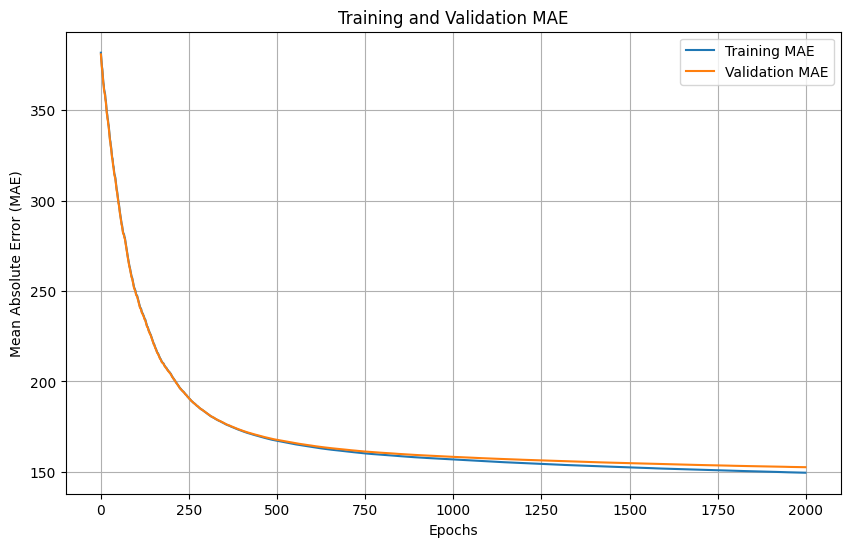

In [46]:
# Ottieni le metriche dal modello
results = model.evals_result()

# Plotta le loss
plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['mae'], label='Training MAE')
plt.plot(results['validation_1']['mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1000x800 with 0 Axes>

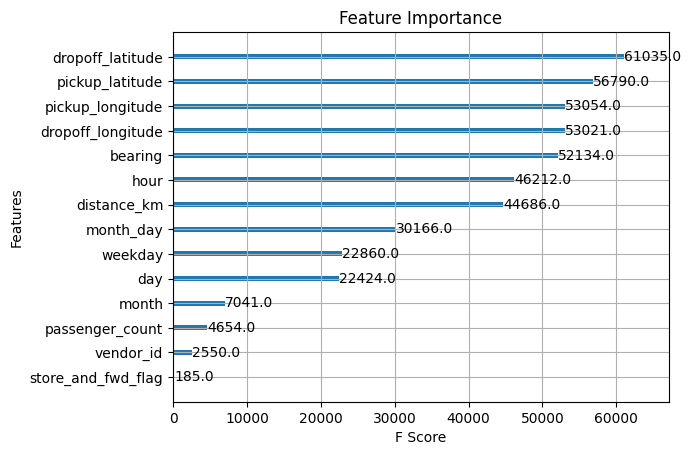

In [47]:
model.get_booster().feature_names = list(X.columns)

plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=20, importance_type="weight", xlabel="F Score")
plt.title("Feature Importance")
plt.show()

## Model Evaluation

## BRUTTA

In [ ]:
df.head(1)

In [ ]:
df_test.head(1)

In [ ]:
print(df.columns)
print(df_test.columns)

In [ ]:
print(df.info())
print(df_test.info())